# Unit 1 Project- Buffalo 311 Open Data Analysis
---
DAT 512 Canisuis College <br>
Zachary Lundy<br>
<br>

### Learning Objectives
---
To allow students to demonstrate the following competencies:
- Functional working knowledge of python using the data analyst workflow
- Jupyter notebook capabilities, file names, folder structure, documentation in comments and markdown, clonable and repeatable
- Ability to move data into pandas and perform data cleansing and manipulation
- Acquire data programmatically from internet resources (within the notebook)
- Create compelling visualizations working the notebook
- Combine multiple datasets into a thoughtful, performative data model
- Ability to store and retrieve data files from local sources
- Creation and committed GitHub repo

### Sections
- [Open Buffalo APIs](#open_buffalo_apis)
- [Filtering the 311 Data](#Filter_311_Data)
- [Data Manipulation & Calculation](#Data_Manipulation_&_Calculations)
- [Data Merging](#Data_Merging)
- [Saving Data as CSV](#Saving_Data_as_CSV)
- [EDA Visuals & Data Models](#EDA_Visuals_&_Data_Models)



# Goal: EDA analysis exploring 311 calls in neighborhoods based on total value

<a id='open_buffalo_apis'></a>
# Open Buffalo APIs

In [1]:
import requests
import pandas as pd

In [2]:
#API for the 311 Buffalo Data
#Selecting 2022 as year
#Limiting to 100,000 rows
params_dict_311 = {
    '$where':"date_extract_y(open_date)=2022",
    '$limit':100000
}

uri_311 = 'https://data.buffalony.gov/resource/whkc-e5vr.json'

r_311 =requests.get(uri_311,params=params_dict_311)
print('Status code:',r_311.status_code)
print('Number of rows returned:',len(r_311.json()))
print('Endoced URI with params:',r_311.url)

Status code: 200
Number of rows returned: 99546
Endoced URI with params: https://data.buffalony.gov/resource/whkc-e5vr.json?%24where=date_extract_y%28open_date%29%3D2022&%24limit=100000


In [3]:
#Convert from JSON to DataFrame
df311=pd.DataFrame(r_311.json())
#Change colums for open/close date to datetime
df311['open_date']=pd.to_datetime(df311['open_date'])
df311['closed_date']=pd.to_datetime(df311['closed_date'])

In [4]:
#API for the 2021-2022 Assessment Roll
#Limiting to 100,000 rows
params_dict_assessment = {
    '$limit':100000
}

uri_assessment = 'https://data.buffalony.gov/resource/2c7u-hywd.json'

r_assessment =requests.get(uri_assessment,params=params_dict_assessment)
print('Status code:',r_assessment .status_code)
print('Number of rows returned:',len(r_assessment .json()))
print('Endoced URI with params:',r_assessment .url)

Status code: 200
Number of rows returned: 93653
Endoced URI with params: https://data.buffalony.gov/resource/2c7u-hywd.json?%24limit=100000


In [5]:
#Convert from JSON to DataFrame
df_assessment=pd.DataFrame(r_assessment.json())

<a id='Filter_311_Data'></a>
# Filtering the 311 Data


In [6]:
# Building Open Cases Data (2022) by subsetting the status that is 'Open'
open311 = df311[df311.status.str.contains("Open")]

In [7]:
# Building Closed Cases Data (2022) by subsetting the status that is 'Closed'
closed311 = df311[df311.status.str.contains("Closed")]

In [8]:
#Selecting columns for analysis (Open Cases)
#Open date, Closed Date, and Neighborhood
open311filtered = open311[["open_date", "subject", "neighborhood"]].copy()

In [9]:
#Selecting columns for analysis (Assessment Roll Data 2021-2022)
#Open date, Total Value, and Land Value
assessment_filtered = df_assessment[["neighborhood", "total_value", "land_value"]].copy()

<a id='Data_Manipulation_&_Calculations'></a>
# Data Manipulation & Calculations

In [10]:
#Create the variable Days_Open which subtracts the open_date from today()
open311filtered.loc[:,"Days_Open"] = (pd.Timestamp.today() - open311filtered["open_date"]).dt.days

In [11]:
#Selecting columns for analysis (Closed Cases)
#Open date, Closed Date, and Neighborhood
closed311filtered = closed311[["open_date","closed_date","subject", "neighborhood"]].copy()

In [12]:
#Create the variable Days_Open from subtracting the close_date from the open_date
closed311filtered["Days_Open"] = (closed311filtered["closed_date"] - closed311filtered["open_date"]).dt.days

In [13]:
#Count the open cases per neighborhood by grouping on neighborhood then counting instances
final311open = open311filtered.groupby(['neighborhood'])['neighborhood'].count().reset_index(name="Current_Open_Cases")
#Create Average Case Length by grouping by neighborhood and taking the mean of Days_Open
final311closed = closed311filtered.groupby('neighborhood')['Days_Open'].mean().reset_index(name="Average_Case_Length")

In [14]:
#Change the variable type to float to prevent inf during calculation
assessment_filtered["total_value"] = assessment_filtered["total_value"].astype("float")
#Create Average Total Value after grouping by neighborhood and taking the mean
final_total_assessment = assessment_filtered.groupby('neighborhood')['total_value'].mean().reset_index(name="Average_Total_Value_Thousands")
#Divide the result by 1000 nicer format than scientific notation
final_total_assessment['Average_Total_Value_Thousands'] = final_total_assessment['Average_Total_Value_Thousands']/1000

#Change the variable type to float to prevent inf during calculation
assessment_filtered["land_value"] = assessment_filtered["land_value"].astype("float")
#Create Average Land Value after grouping by neighborhood and taking the mean
final_land_assessment = assessment_filtered.groupby('neighborhood')['land_value'].mean().reset_index(name="Average_Land_Value_Thousands")
#Divide the result by 1000 nicer format than scientific notation
final_land_assessment['Average_Land_Value_Thousands'] = final_land_assessment['Average_Land_Value_Thousands']/1000

<a id='Data_Merging'></a>
# Data Merging

In [15]:
#Merge the data from the open cases and the closed cases after calculations
#Provides Current Open Cases and Average Case Length by Neighborhood
final311 = pd.merge(final311open, final311closed, left_on="neighborhood", right_on="neighborhood", how="inner")

In [16]:
#Merge the data from the total value and the land value after calculations
#Provides Average Total Value (1k) and Average Land Value (1k) by Neighborhood
final_assessment = pd.merge(final_total_assessment, final_land_assessment,left_on="neighborhood", right_on="neighborhood", how="inner" )

In [17]:
#Final merge of the 311 data and Assessment Data
#Provides Current Open Cases, Avg. Case Length, Avg. Total Value (1k), Avg. Land Value (1k) by Neighborhood
final_buffalo = pd.merge(final311, final_assessment,left_on="neighborhood", right_on="neighborhood", how="inner")
final_buffalo.head()

,neighborhood,Current_Open_Cases,Average_Case_Length,Average_Total_Value_Thousands,Average_Land_Value_Thousands
0,Allentown,31,6.289116,409.477481,64.319943
1,Black Rock,24,11.024106,90.304952,8.680272
2,Broadway Fillmore,100,9.501656,35.532883,4.664294
3,Central,70,7.334488,1584.112691,194.444862
4,Central Park,37,8.460790,265.900407,59.463394


<a id='Saving_Data_as_CSV'></a>
# Saving Data as CSV

In [18]:
open311filtered.to_csv("dataFiles/open311cases.csv")
closed311filtered.to_csv("dataFiles/closed311cases.csv")
final311.to_csv("dataFiles/311cases2022.csv")
final_assessment.to_csv("dataFiles/2022assessment.csv")
final_buffalo.to_csv("dataFiles/finalBuffaloData.csv")

<a id='EDA_Visuals_&_Data_Models'></a>
# EDA Visuals & Data Models

## What dept. tends to get the most 311 calls?

<AxesSubplot:>

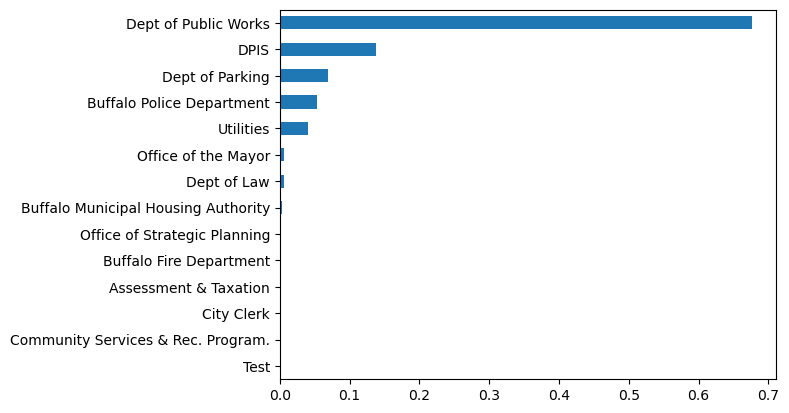

In [19]:
closed311filtered["subject"].value_counts(normalize=True, ascending=True).plot.barh()

### The Dept. of Public Works tends to be called the most as it comprises of about 70% of the total 2022 calls


## Of the open cases, who has the longest average open time?

[Text(0.5, 1.0, 'Open Cases by Department'),
 Text(0, 0.5, 'Department'),
 Text(0.5, 0, 'Average Days Open')]

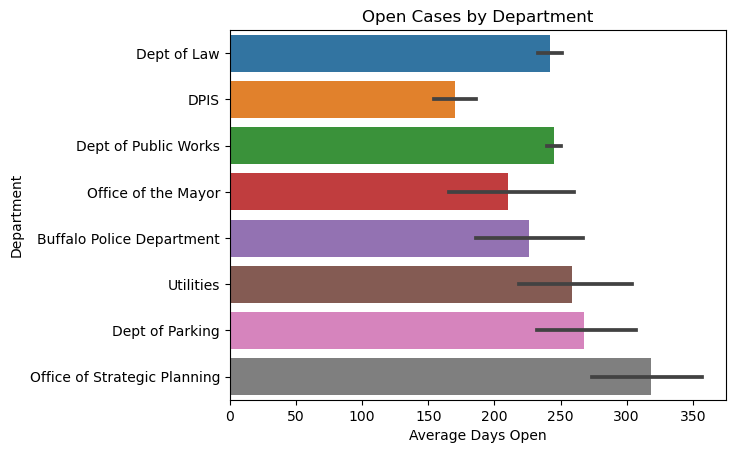

In [20]:
import seaborn as sns
sns.barplot(x="Days_Open", y="subject", data=open311filtered, orient="h").set(
    title='Open Cases by Department', ylabel="Department", xlabel="Average Days Open")

### The Office of Strategic Planning seems to have the highest avg. days open

## Of the closed cases, does the Office of Strategic planning have the highest avg. of days open?

[Text(0.5, 1.0, 'Closed Cases by Department'),
 Text(0, 0.5, 'Department'),
 Text(0.5, 0, 'Average Days Open')]

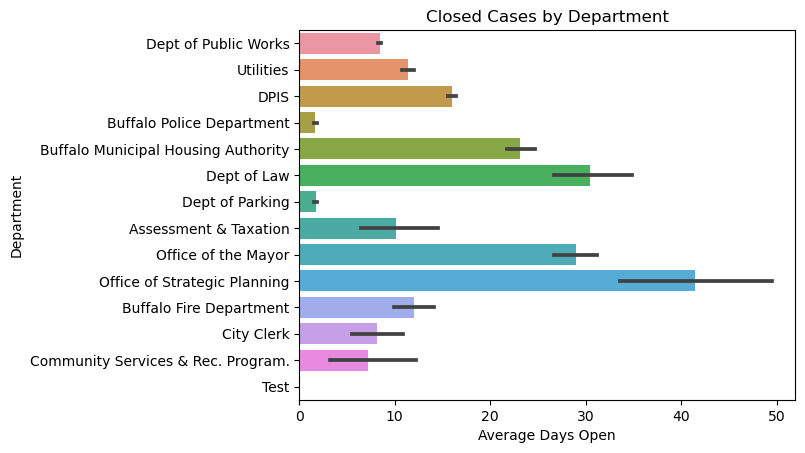

In [21]:
import seaborn as sns
sns.barplot(x="Days_Open", y="subject", data=closed311filtered, orient="h").set(
    title='Closed Cases by Department', ylabel="Department", xlabel="Average Days Open")

### Yes, so it makes sense that some of the projects from 2022 are still open. For eaxmple, a project could have been started late 2022 going into 2023. So the open cases generally tend to follow the trend of the closed cases. 

### What does the Avg. Total Value by neighborhood look like?

[Text(0.5, 1.0, 'Total Land Value by Neighborhood'),
 Text(0, 0.5, 'Neighborhood'),
 Text(0.5, 0, 'Average Total Value (1k)')]

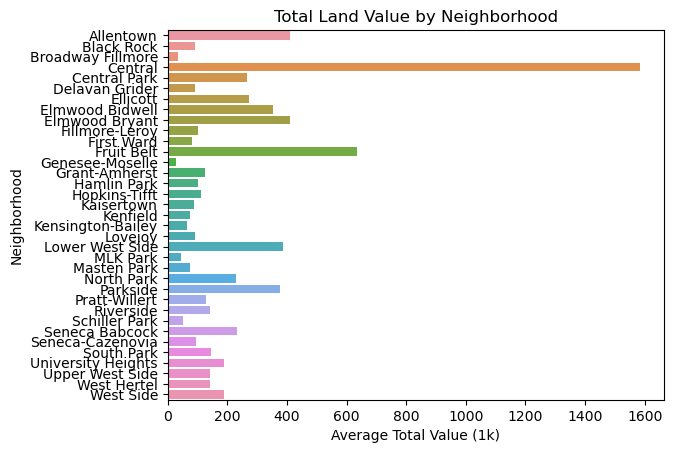

In [22]:
sns.barplot(x="Average_Total_Value_Thousands", y="neighborhood",
            data=final_buffalo).set(
    title='Total Land Value by Neighborhood', ylabel="Neighborhood", xlabel="Average Total Value (1k)")

### Central seems to have the most total vlaue and Broadway-Fillmore/Genesee-Moselle the least

## Is there an inverse realtionship between Total Value and Open Cases?

[Text(0.5, 1.0, 'Current Open Cases by Neighborhood'),
 Text(0, 0.5, 'Neighborhood'),
 Text(0.5, 0, 'Current Open Cases')]

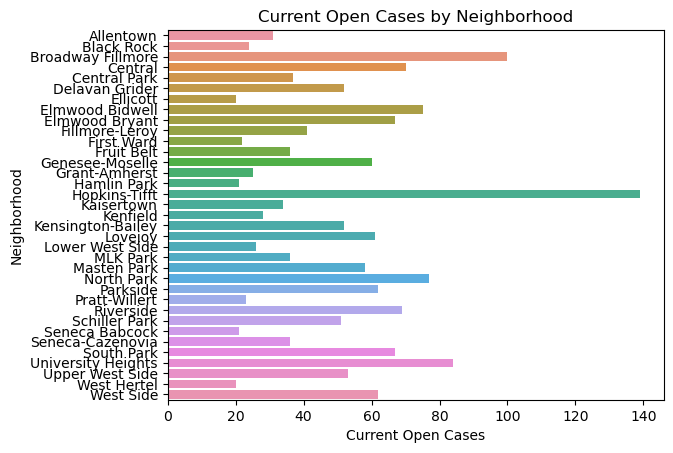

In [23]:
sns.barplot(x="Current_Open_Cases", y="neighborhood",
            data=final_buffalo).set(
    title='Current Open Cases by Neighborhood', ylabel="Neighborhood", xlabel="Current Open Cases")

### It does seem that there could be an inverse correlation between total value and number of open cases

## Investigate the previous claim with a correlation matrix

In [24]:
final_buffalo.corr()

,Current_Open_Cases,Average_Case_Length,Average_Total_Value_Thousands,Average_Land_Value_Thousands
Current_Open_Cases,1.000000,-0.279275,0.080669,0.137300
Average_Case_Length,-0.279275,1.000000,-0.357179,-0.460801
Average_Total_Value_Thousands,0.080669,-0.357179,1.000000,0.943031
Average_Land_Value_Thousands,0.137300,-0.460801,0.943031,1.000000


### There is not a strong correlation between open cases and avg. total value. The strongest correlation is between land and total value (this makes sense). Further analysis, might want to explore if there is a relationship between total value and crime per capita (neighborhood), or plot 311 calls against 911 calls. 